# 02_session_id_without_created_at

## PartA: object_id_frequency analysis

### Assumptions
1. Segment the session by participant_id continuity within each event_id,
2. If object_id appears repeatedly within an event, or there is "block aggregation", it is possible to proceed to the next step of analysis

### Finding
However, according to the results shown in the image, there is no way to manually verify. 

### Reason
1. Because we don't have a timestamp. We can't know "who comes first and who comes later", so even if we see the same participant_id appear multiple times, we can't guarantee that these records are completed in the same session.
2. This type of session_id cannot match data with timestamps.
3. Manual verification of the order of sessions is also impossible in the absence of time. So give up

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import igraph as ig
from leidenalg import find_partition, RBConfigurationVertexPartition
from igraph import Graph
import collections

In [2]:
# loading 
df = pd.read_csv("/Users/olivey/Downloads/sample.csv")
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')

# data without create_at 
df_no_time = df[df['created_at'].isna()].copy()

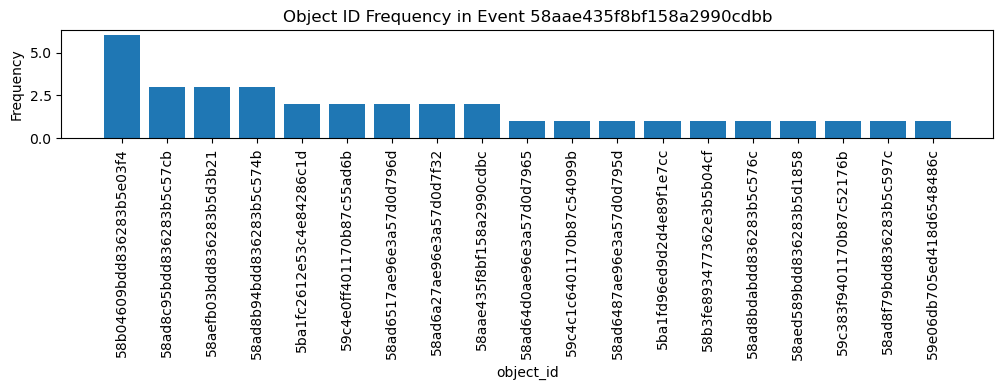

count    19.000000
mean      1.842105
std       1.258887
min       1.000000
25%       1.000000
50%       1.000000
75%       2.000000
max       6.000000
Name: count, dtype: float64
 The top few object_id occurrence frequencies:
object_id
58b04609bdd836283b5e03f4    6
58ad8c95bdd836283b5c57cb    3
58aefb03bdd836283b5d3b21    3
58ad8b94bdd836283b5c574b    3
5ba1fc2612e53c4e84286c1d    2
59c4e0ff401170b87c55ad6b    2
58ad6517ae96e3a57d0d796d    2
58ad6a27ae96e3a57d0d7f32    2
58aae435f8bf158a2990cdbc    2
58ad64d0ae96e3a57d0d7965    1
Name: count, dtype: int64


In [3]:
# find the event_id with the most records
target_event = df_no_time['event_id'].value_counts().idxmax()
df_event = df_no_time[df_no_time['event_id'] == target_event]

# frequency of object_id
object_counts = df_event['object_id'].value_counts()


plt.figure(figsize=(10, 4))
plt.bar(object_counts.index.astype(str), object_counts.values)
plt.xticks(rotation=90)
plt.title(f"Object ID Frequency in Event {target_event}")
plt.xlabel("object_id")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

#statistics 
print(object_counts.describe())

print(" The top few object_id occurrence frequencies:")
print(object_counts.head(10))


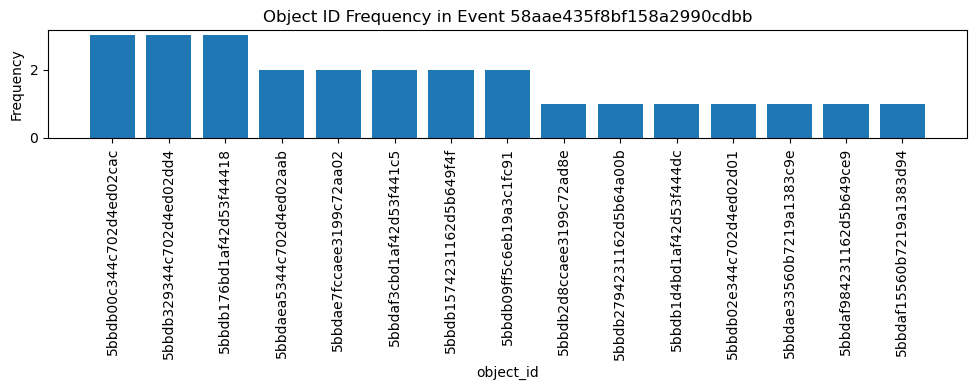

In [4]:
# FOR ANOTHER HIGH FREQUENCY EVENT_ID
df_event = df_no_time[df_no_time['event_id'] =='5bbda4ff560b7219a13833bb']
object_counts = df_event['object_id'].value_counts()

plt.figure(figsize=(10, 4))
plt.bar(object_counts.index.astype(str), object_counts.values)
plt.xticks(rotation=90)
plt.title(f"Object ID Frequency in Event {target_event}")
plt.xlabel("object_id")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

## PartB: leiden_graph_clustering analysis

### Finding
There is indeed an edge structure between nodes, forming multiple small blocks in the graph, each of which can be regarded as a "speculated session".
### Explanation
1. The cluster with a large center → more credible session
2. Each community is mapped back to the original record, and it can be seen that most sessions have a reasonable structure, and more than 64% of the sessions consist of more than one person


### PartB.1 Take example

In [5]:

# keep at least two recorded event_ids
event_counts = df['event_id'].value_counts()
valid_event_ids = event_counts[event_counts > 1].index
df = df[df['event_id'].isin(valid_event_ids)]

#  graph functions
def build_bipartite_graph(df):
    G = nx.Graph()
    for _, row in df.iterrows():
        obj_node = f"obj_{row['object_id']}"
        user_node = f"user_{row['participant_id']}"
        G.add_edge(obj_node, user_node, weight=1)
    return G

# Leiden function
def leiden_partition(G):
    nodes = list(G.nodes())
    edges = list(G.edges(data=True))
    ig_graph = ig.Graph()
    ig_graph.add_vertices(nodes)
    ig_graph.add_edges([(u, v) for u, v, _ in edges])
    ig_graph.vs['name'] = nodes
    ig_graph.es['weight'] = [d['weight'] for _, _, d in edges]

    partition = find_partition(
        ig_graph,
        RBConfigurationVertexPartition,
        weights=ig_graph.es['weight'],
        resolution_parameter=1.0
    )
    return partition

# example: high-volume event_id
example_event = df['event_id'].value_counts().idxmax()
df_sample = df[df['event_id'] == example_event]

G = build_bipartite_graph(df_sample)
partition = leiden_partition(G)

# output: the community ID of each node
node_community = {node: partition.membership[i] for i, node in enumerate(G.nodes())}
print(f"number of community: {len(set(partition.membership))}")
print("node attribution：", list(node_community.items())[:10])



number of community: 17
node attribution： [('obj_58ad64d0ae96e3a57d0d7965', 1), ('user_z375444299292', 1), ('obj_58ad8b94bdd836283b5c574b', 2), ('user_z955306531065', 2), ('obj_5ba1fd96ed9d2d4e89f1e7cc', 1), ('user_z19369623100', 1), ('obj_5ba1fe695a5d074e909c0cca', 7), ('user_z821499015513', 7), ('obj_58ad8cabbdd836283b5c57e1', 2), ('user_5ba20c2831c09e2da13fcd82', 2)]


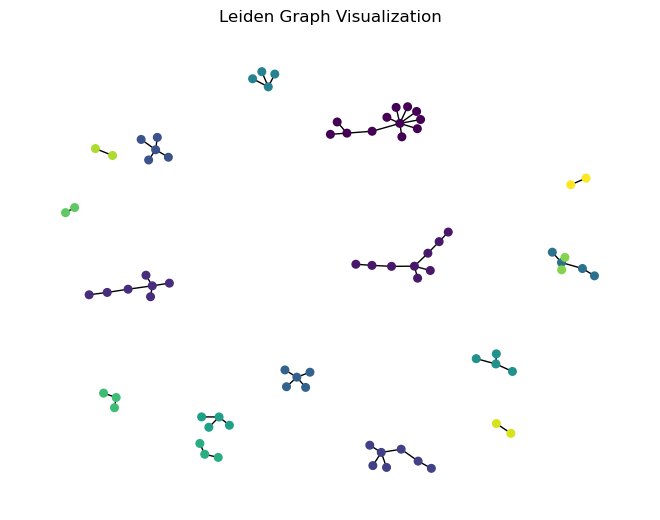

In [6]:
colors = [partition.membership[i] for i in range(len(G.nodes()))]
nx.draw_spring(G, node_color=colors, with_labels=False, node_size=30)
plt.title("Leiden Graph Visualization")
plt.show()


In [7]:
def get_comm(row):
    obj_node = f"obj_{row['object_id']}"
    user_node = f"user_{row['participant_id']}"
    return node_community.get(obj_node) or node_community.get(user_node)

df_sample["session_id"] = df_sample.apply(get_comm, axis=1)

df_sample.groupby("session_id").agg(
    actions=('object_id', 'count'),
    users=('participant_id', 'nunique')
).sort_values("actions", ascending=False)


/var/folders/y8/s09tgd696rzgh3yrjgxyjq0c0000gn/T/ipykernel_55848/17473215.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample["session_id"] = df_sample.apply(get_comm, axis=1)


,actions,users
session_id,,
0,11,10
1,8,6
2,7,5
3,6,5
4,4,4
5,4,4
9,3,3
8,3,3
7,3,3


In [8]:
modularity_score = partition.modularity
print(f"Modularity: {modularity_score:.4f}")
# 0.3 indicates obvious clustering


Modularity: 0.9061


### PartB.2 applied on the sample.csv

In [11]:
all_stats = []

for event_id, group in df.groupby("event_id"):
    G = build_bipartite_graph(group)
    if len(G.edges) == 0:
        continue
    try:
        partition = leiden_partition(G)
        num_comms = len(set(partition.membership))
        mod = partition.modularity
        comm_sizes = collections.Counter(partition.membership)
        avg_comm_size = sum(comm_sizes.values()) / len(comm_sizes)
        all_stats.append({
            "event_id": event_id,
            "nodes": len(G.nodes()),
            "edges": len(G.edges()),
            "num_communities": num_comms,
            "avg_community_size": avg_comm_size,
            "modularity": mod
        })
    except Exception as e:
        print(f"jump {event_id} clusteing fail: {e}")

all_stats_df = pd.DataFrame(all_stats)

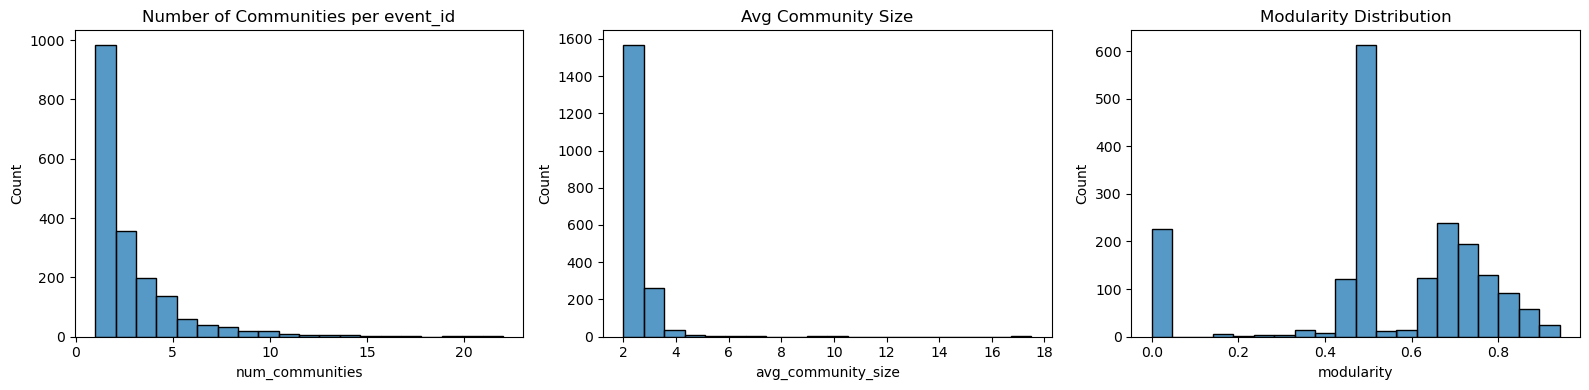

             nodes        edges  num_communities  avg_community_size  \
count  1879.000000  1879.000000      1879.000000         1879.000000   
mean      7.488558     4.304949         3.205428            2.334374   
std       6.490162     4.379511         2.351976            0.638380   
min       2.000000     1.000000         1.000000            2.000000   
25%       4.000000     2.000000         2.000000            2.000000   
50%       5.000000     3.000000         2.000000            2.000000   
75%       9.000000     5.000000         4.000000            2.500000   
max      77.000000    60.000000        22.000000           17.500000   

        modularity  
count  1879.000000  
mean      0.541048  
std       0.239654  
min       0.000000  
25%       0.500000  
50%       0.500000  
75%       0.720000  
max       0.942149  


In [12]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))

sns.histplot(all_stats_df['num_communities'], bins=20, ax=axs[0])
axs[0].set_title("Number of Communities per event_id")

sns.histplot(all_stats_df['avg_community_size'], bins=20, ax=axs[1])
axs[1].set_title("Avg Community Size")

sns.histplot(all_stats_df['modularity'], bins=20, ax=axs[2])
axs[2].set_title("Modularity Distribution")

plt.tight_layout()
plt.show()

print(all_stats_df.describe())


### Finding: 
 According to the number of communities per event_id --> no over spilting problem
 The average community size is between 2.0 and 3.0
 The median modularity is about 0.53, many events exceed 0.7, and the maximum can reach 0.93 -- > Most graphs have significant structure
### Conclusion: 
 The community structure of most graphs is reasonable, and clustering is effective